# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки, объявим функции, зафиксируем рандомстейт.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import phik
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [7]:
class MyDummyModel(BaseEstimator):
    def __init__(self, base_feature=None):
        self.base_feature = base_feature
        self.coef = 1
        
    def fit(self, X, y):
        if self.base_feature is None:
            self.base_feature = X.columns[0]
        self.is_fitted_ = True
        self.coef = y.mean() / X[self.base_feature].mean()
        return self
        
    def predict(self, X):
        return X[self.base_feature] * self.coef


def add_features(df, lag_list, rolling_size):
    df_copy = df.copy()
    
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek

    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_size).mean()

    for lag in lag_list:
        df_copy[f'num_orders_lag_{lag}'] = df_copy['num_orders'].shift(lag)

    return df_copy


def display_seasonal_decompose(decomposed_data, ax1, ax2, ax3):
    decomposed_data.trend.plot(ax=ax1)
    ax1.set_title('Тренд')
    ax1.set_xlabel('Дата')
    ax1.set_ylim(bottom=0)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(alpha=0.5, linestyle=':')
    
    decomposed_data.seasonal.plot(ax=ax2)
    ax2.set_title('Сезонная составляющая')
    ax2.set_xlabel('Дата')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(axis='both', which='both', alpha=0.5, linestyle=':')
    
    decomposed_data.resid.plot(ax=ax3)
    ax3.set_title('Остаток декомпозиции')
    ax3.set_xlabel('Дата')
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.grid(alpha=0.5, linestyle=':')

In [8]:
RANDOM_STATE = 42

### Загрузка данных

Считаем CSV-файл с данными и сохраним его в датафрейм `taxi`. Изучим общую информацию о датафрейме.

In [11]:
csv_local = 'datasets/taxi.csv'
csv_remote = 'https://example.com/datasets/taxi.csv'
if os.path.exists(csv_local):
    taxi = pd.read_csv(csv_local, parse_dates=['datetime'], index_col=['datetime'])
else:
    taxi = pd.read_csv(csv_remote, parse_dates=['datetime'], index_col=['datetime'])

In [12]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [13]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Датафрем `taxi` содержит временной ряд с количеством заказов в столбце `num_orders` с интервалами в 10 минут. 

### Предобработка данных

Проверим пропуски.

In [17]:
taxi.isna().sum().sum()

0

Пропусков нет. Проверим дубликаты.

In [19]:
taxi.index.duplicated().sum()

0

Дубликатов нет. Отсортируем датафрейм по индексу с датой и временем. Проверим «монотонность» временного ряда.

In [21]:
taxi.sort_index(inplace=True)
taxi.index.is_monotonic_increasing

True

Поскольку перед нами стоит задача спрогнозировать количество заказов такси на следующий час, ресемплируем временной ряд, взяв интервалы в 1 час. Результат сохраним в датафрейм `taxi_1h`.

In [23]:
taxi_1h = taxi.resample('1h').sum()
taxi_1h.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

### Основные характеристики

Посмотрим на числовое описание индекса.

In [27]:
taxi_1h.index.to_frame().describe().T

,count,mean,min,25%,50%,75%,max
datetime,4416,2018-05-31 23:30:00,2018-03-01 00:00:00,2018-04-15 23:45:00,2018-05-31 23:30:00,2018-07-16 23:15:00,2018-08-31 23:00:00


У нас есть данные с 1 марта 2018 года по 31 августа 2018 года (включительно).

Посмотрим на числовое описание целевого признака.

In [30]:
taxi_1h.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


Построим диаграмму размаха целевого признака.

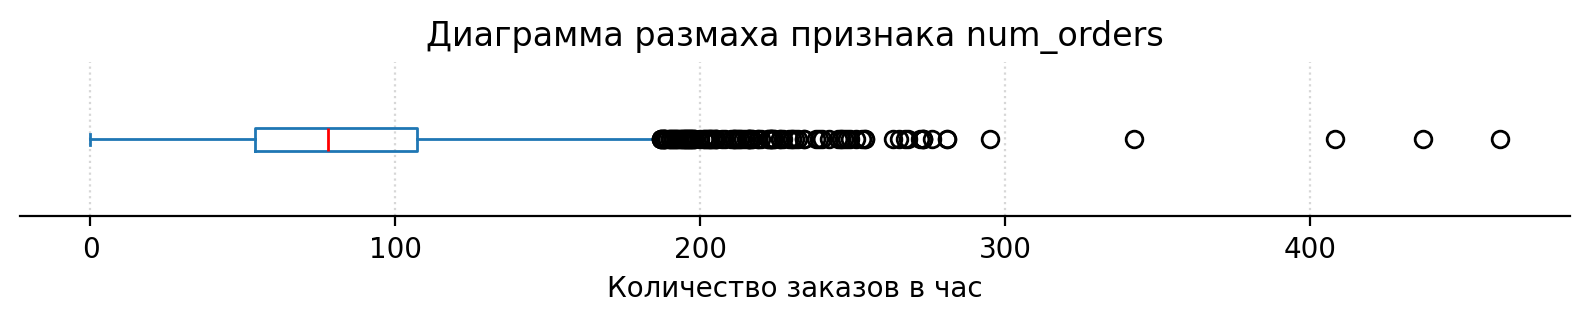

In [32]:
fig, ax = plt.subplots(figsize=(10, 1))

taxi_1h['num_orders'].plot(kind='box', vert=False, ax=ax, medianprops={'color': 'red'})
ax.set_title('Диаграмма размаха признака num_orders')
ax.set_xlabel('Количество заказов в час')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')

plt.show()

Есть выбросы, но вполне допустимые.

Посмотрим на среднее количество заказов в час (в каждый из 24 часов в сутках).

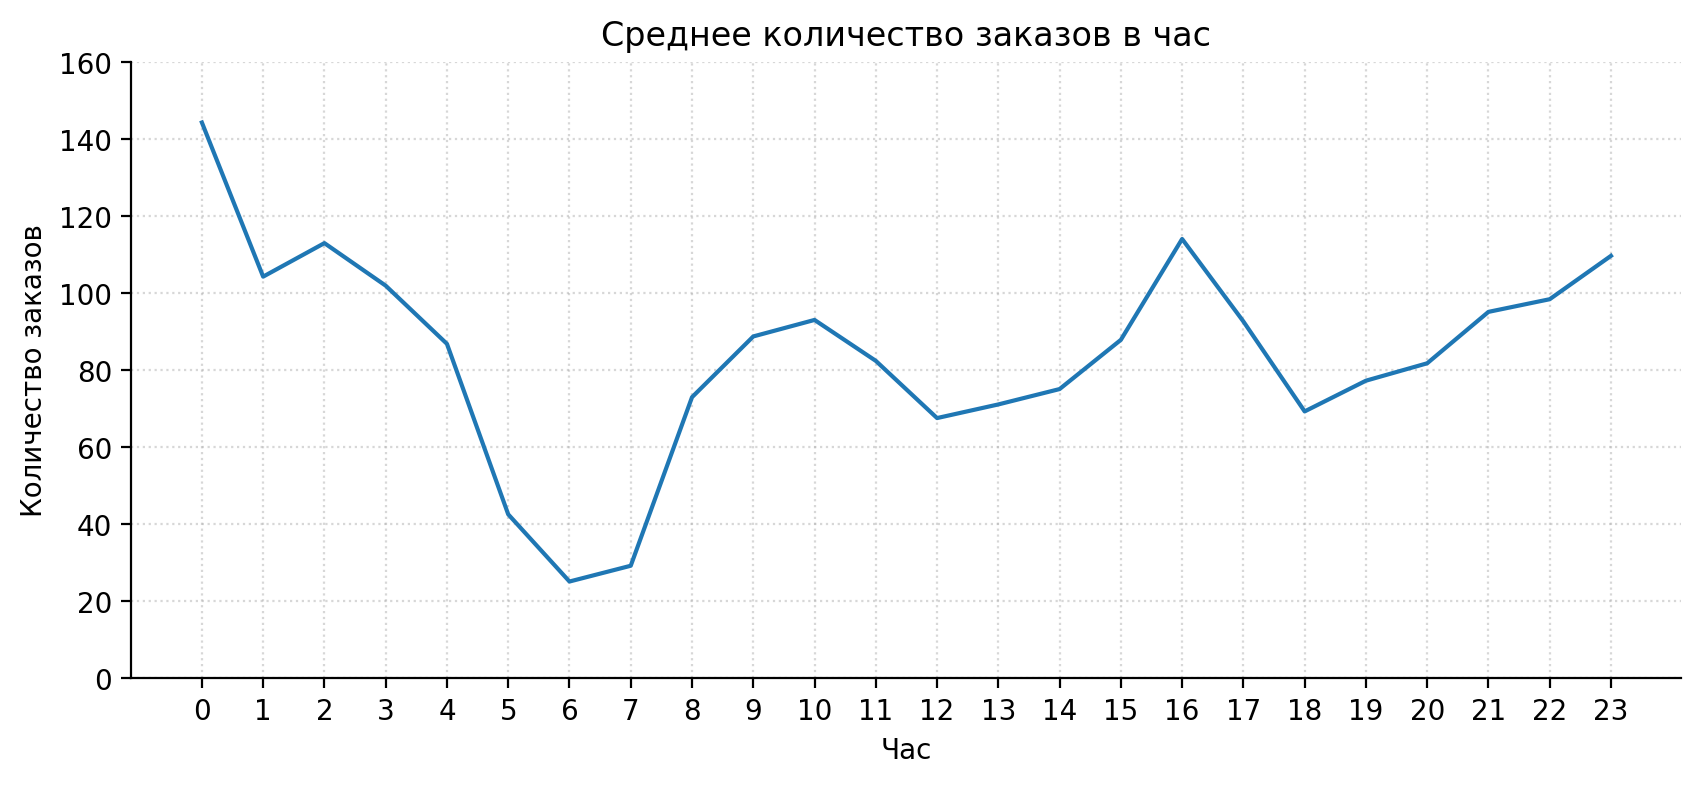

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))

taxi_1h.groupby(taxi_1h.index.hour)['num_orders'].mean().plot(ax=ax)
ax.set_title('Cреднее количество заказов в час')
ax.set_xlabel('Час')
ax.set_ylabel('Количество заказов')
ax.set_xticks(range(24))
ax.set_ylim(top=160, bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

Заметно снижение количества заказов в ранне-утренние часы.

Посмотрим на среднее количество заказов в день (в каждый из 7 дней недели).

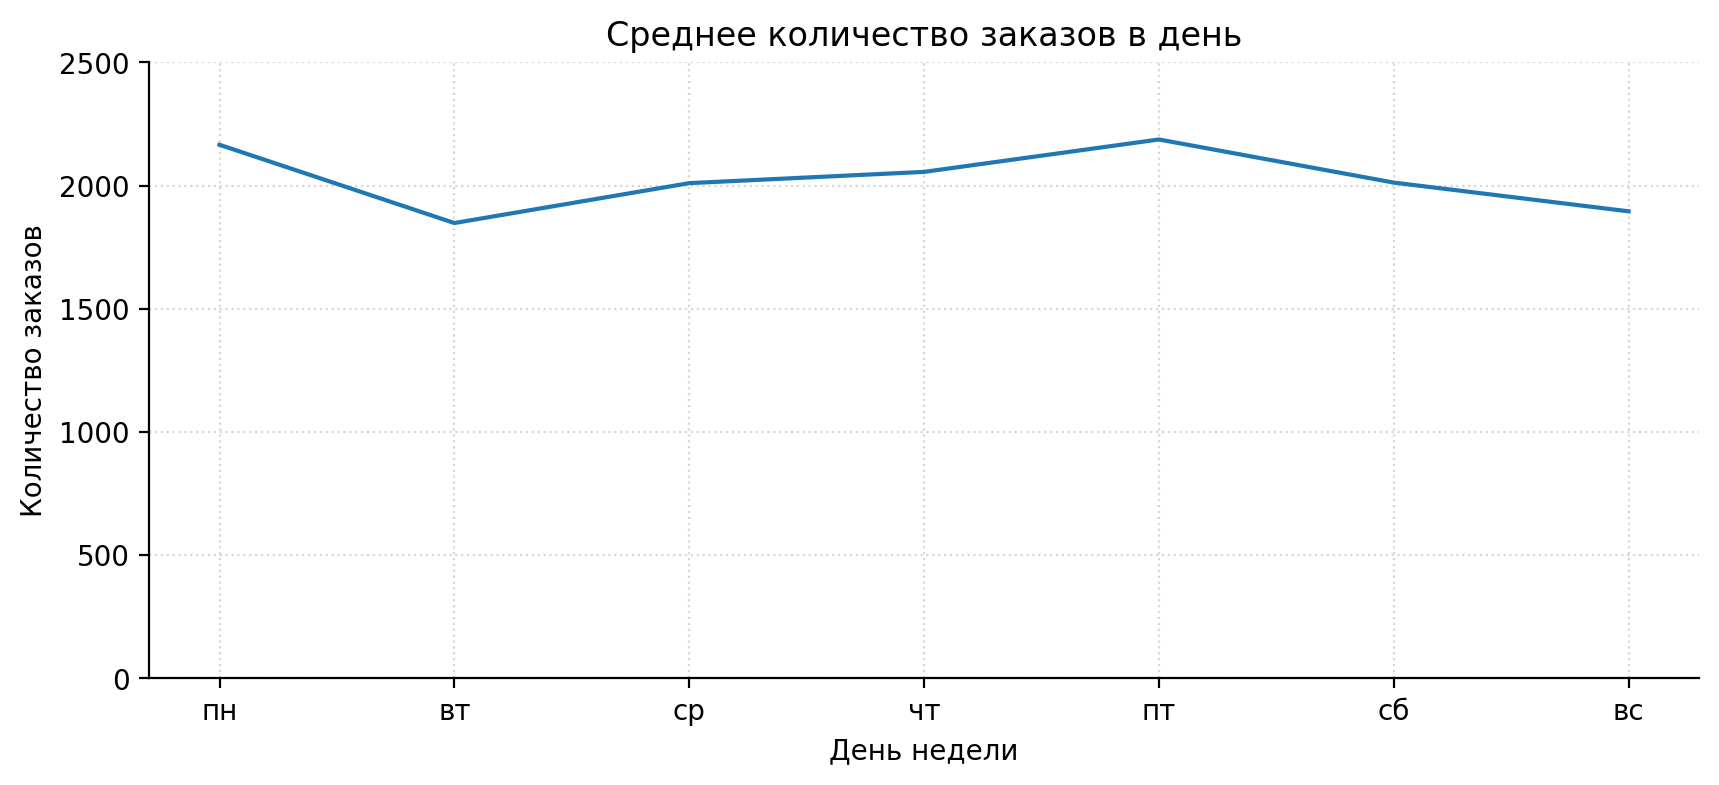

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))

taxi_1d = taxi_1h.resample('1D').sum()
taxi_1d.groupby(taxi_1d.index.dayofweek)['num_orders'].mean().plot(ax=ax)
ax.set_title('Cреднее количество заказов в день')
ax.set_xlabel('День недели')
ax.set_ylabel('Количество заказов')
ax.set_xticklabels(['', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])
ax.set_ylim(top=2500, bottom=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

По понедельникам и пятницам заказов больше, чем в другие дни недели.

Построим график временного ряда, ресемплированного по часам, со скользящим средним с размером окна в неделю.

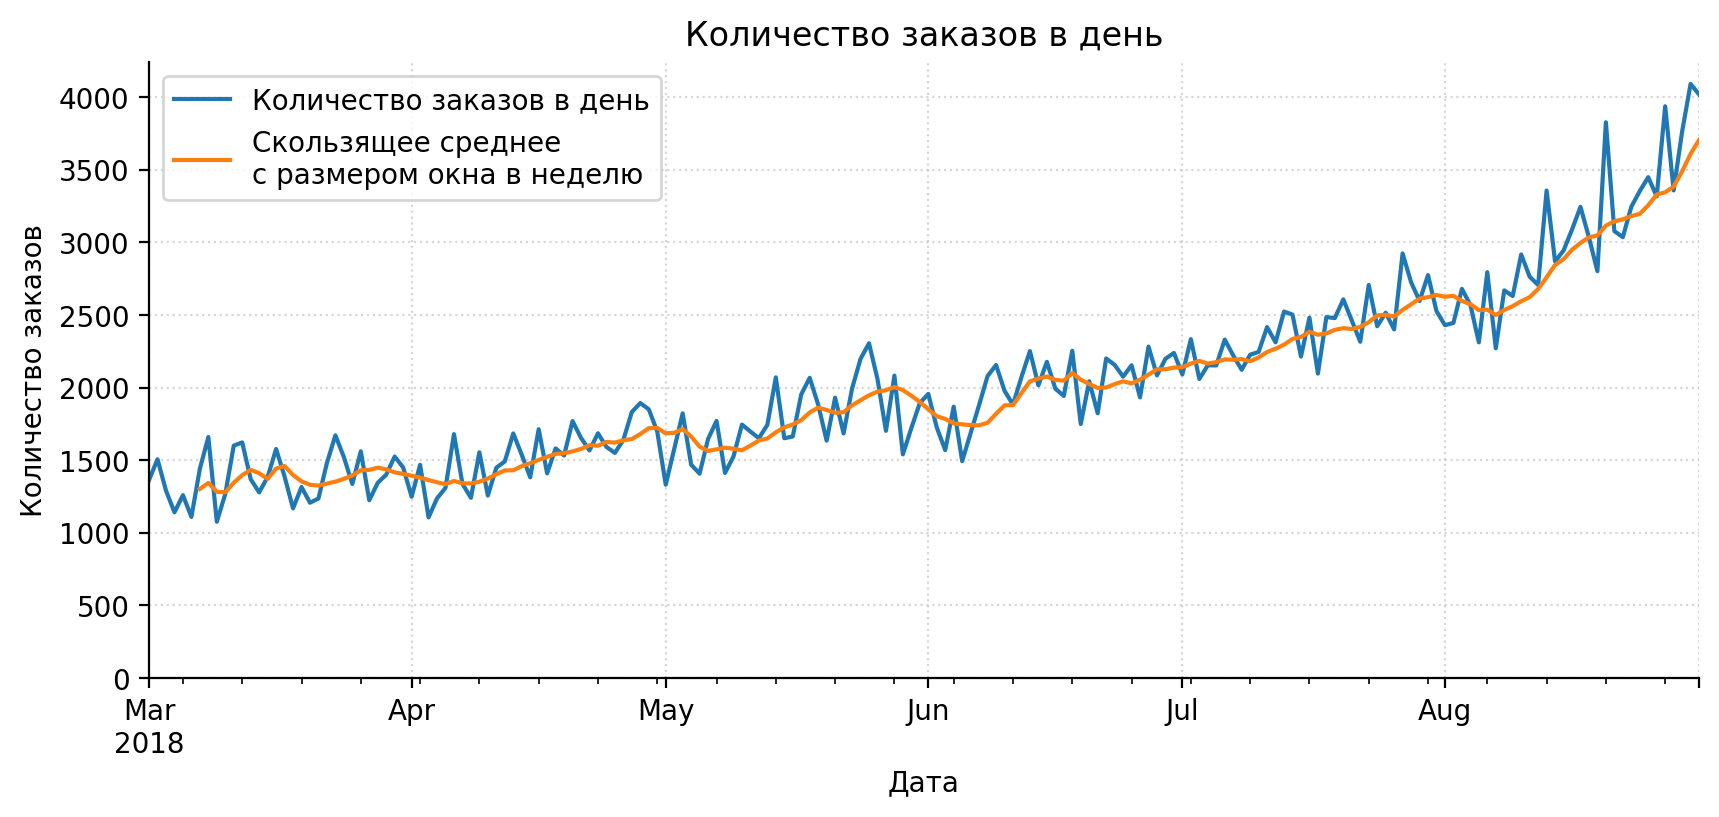

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))

taxi_1d.assign(rolling_mean=taxi_1d['num_orders'].rolling(7).mean()).plot(ax=ax)
ax.set_title('Количество заказов в день')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.set_ylim(bottom=0)
ax.legend(['Количество заказов в день', 'Скользящее среднее\nс размером окна в неделю'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

Похоже на то, что количество заказов постепенно растет.

Вычислим разности временного ряда. Посмотрим на скользящее среднее и скользящее стандартное отклонение.

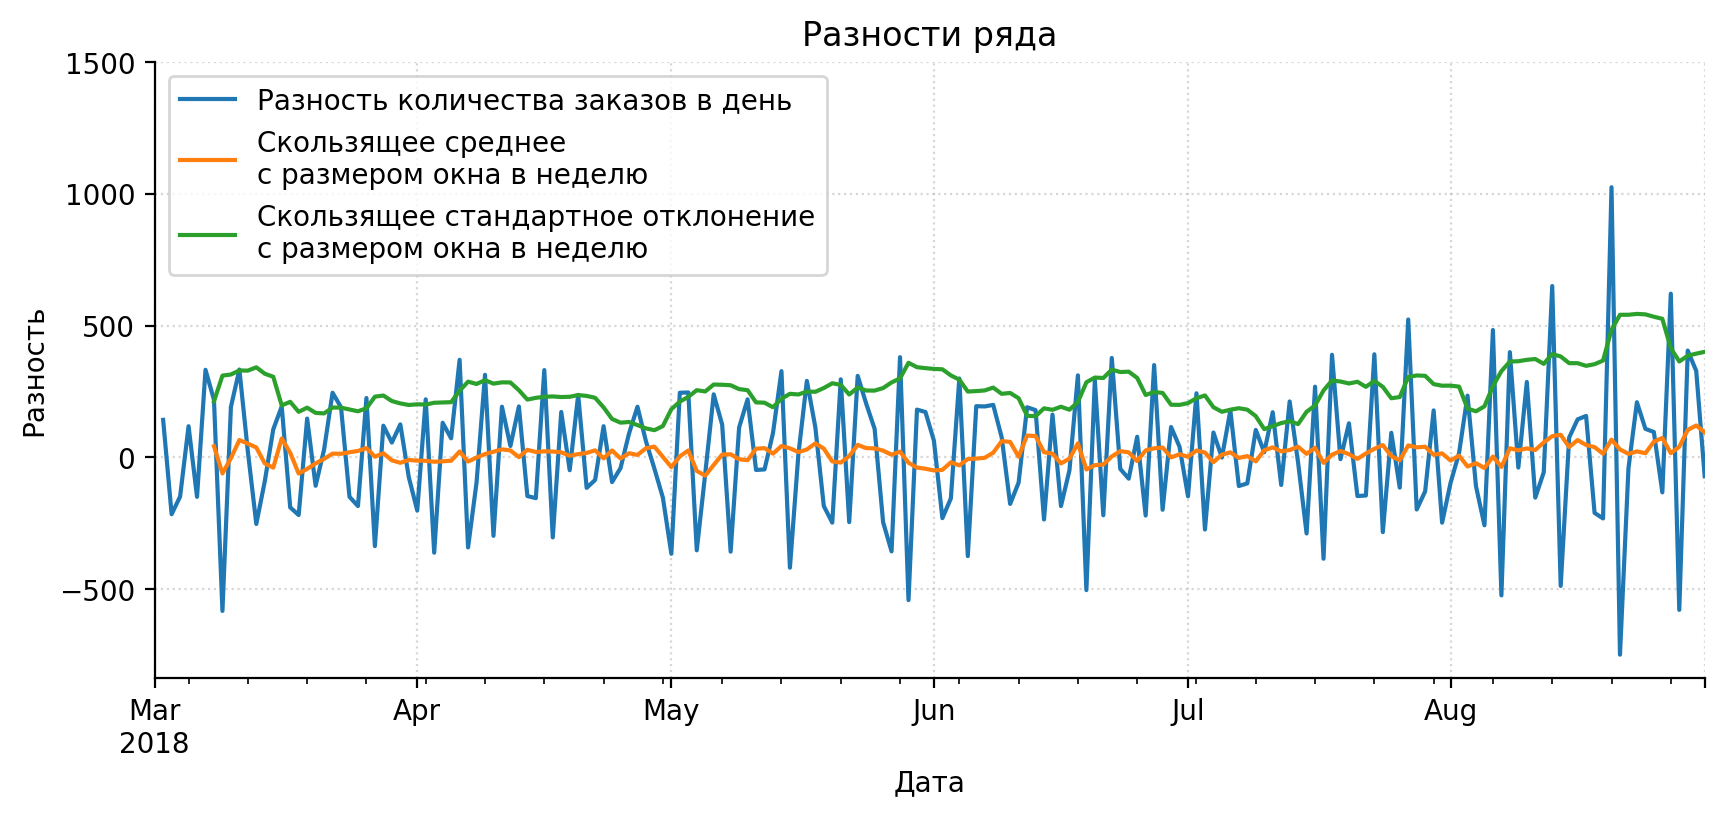

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))

(taxi_1d - taxi_1d.shift()) \
.assign(mean_1w=lambda x: x['num_orders'].rolling(7).mean(), 
        std_1w=lambda x: x['num_orders'].rolling(7).std()) \
.plot(ax=ax)
ax.set_title('Разности ряда')
ax.set_xlabel('Дата')
ax.set_ylabel('Разность')
ax.set_ylim(top=1500)
ax.legend(['Разность количества заказов в день', 
           'Скользящее среднее\nс размером окна в неделю',
           'Скользящее стандартное отклонение\nс размером окна в неделю'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

Временной ряд стал более стационарным — следовательно, данные можно прогнозировать.

### Тренды и сезонность

#### Ресемплирование по дням

Попробуем выделить тренд и сезонность из данных, ресемплированных по дням.

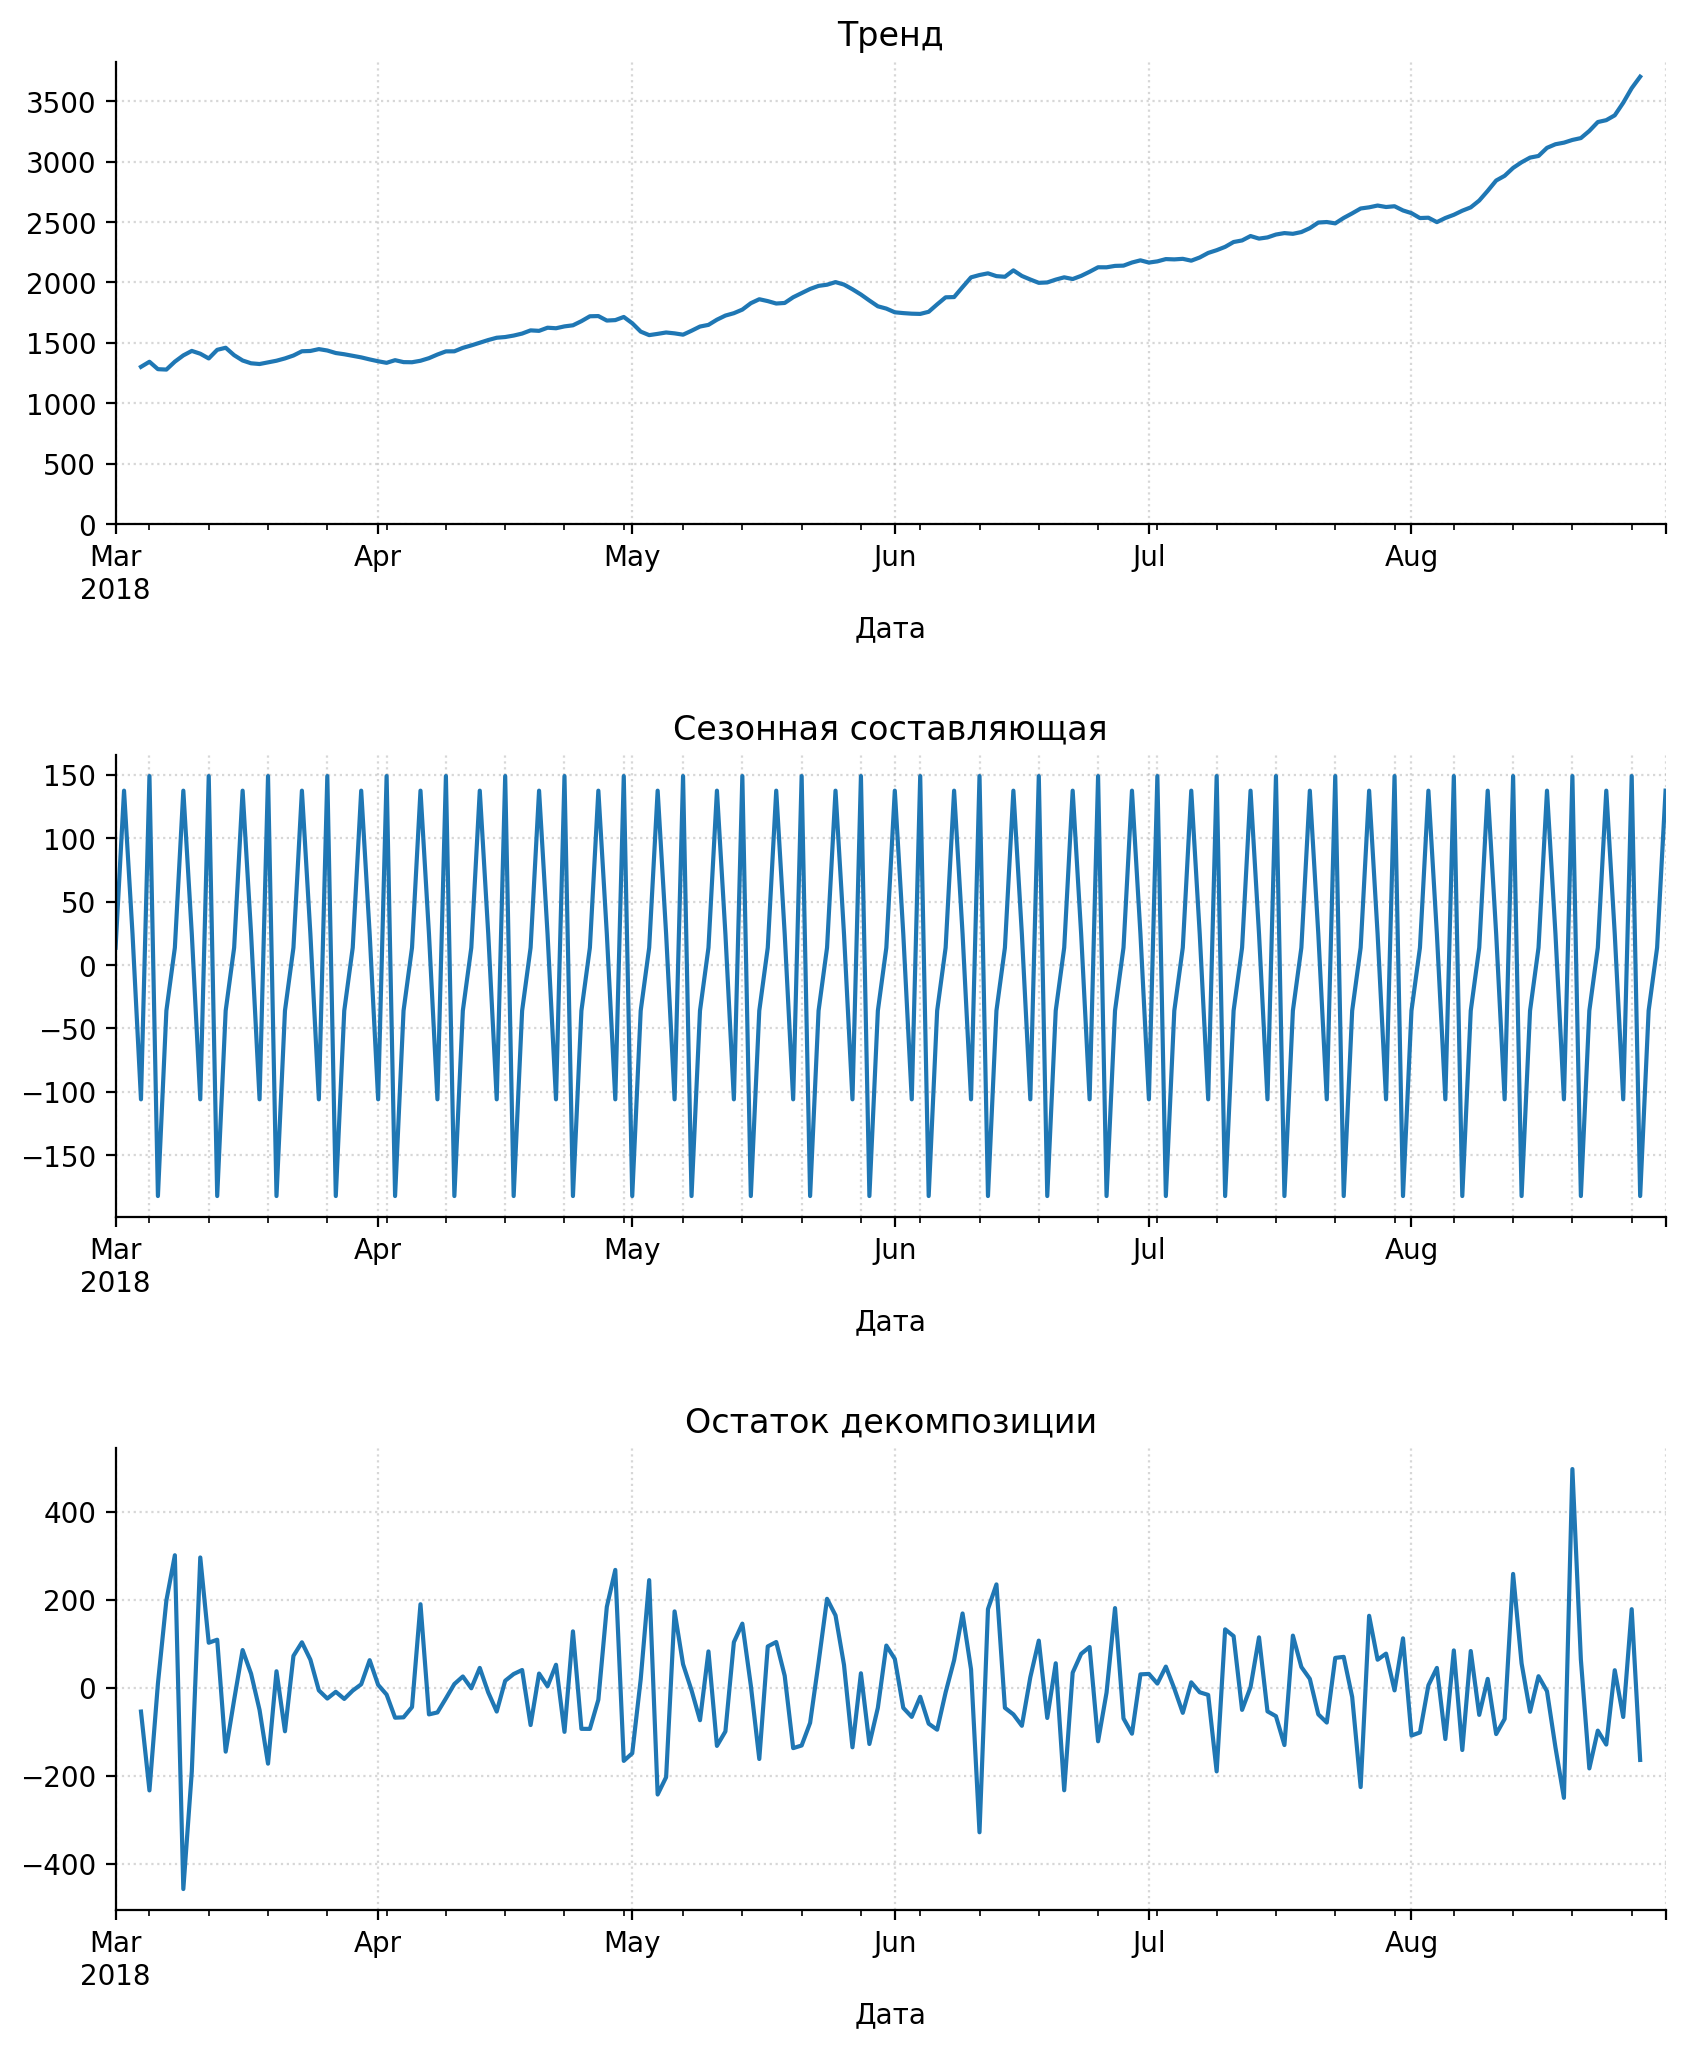

In [49]:
decomposed_taxi_1d = seasonal_decompose(taxi_1d)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)
display_seasonal_decompose(decomposed_taxi_1d, ax1, ax2, ax3)
plt.show()

Посмотрим на сезонную составляющую внимательнее.

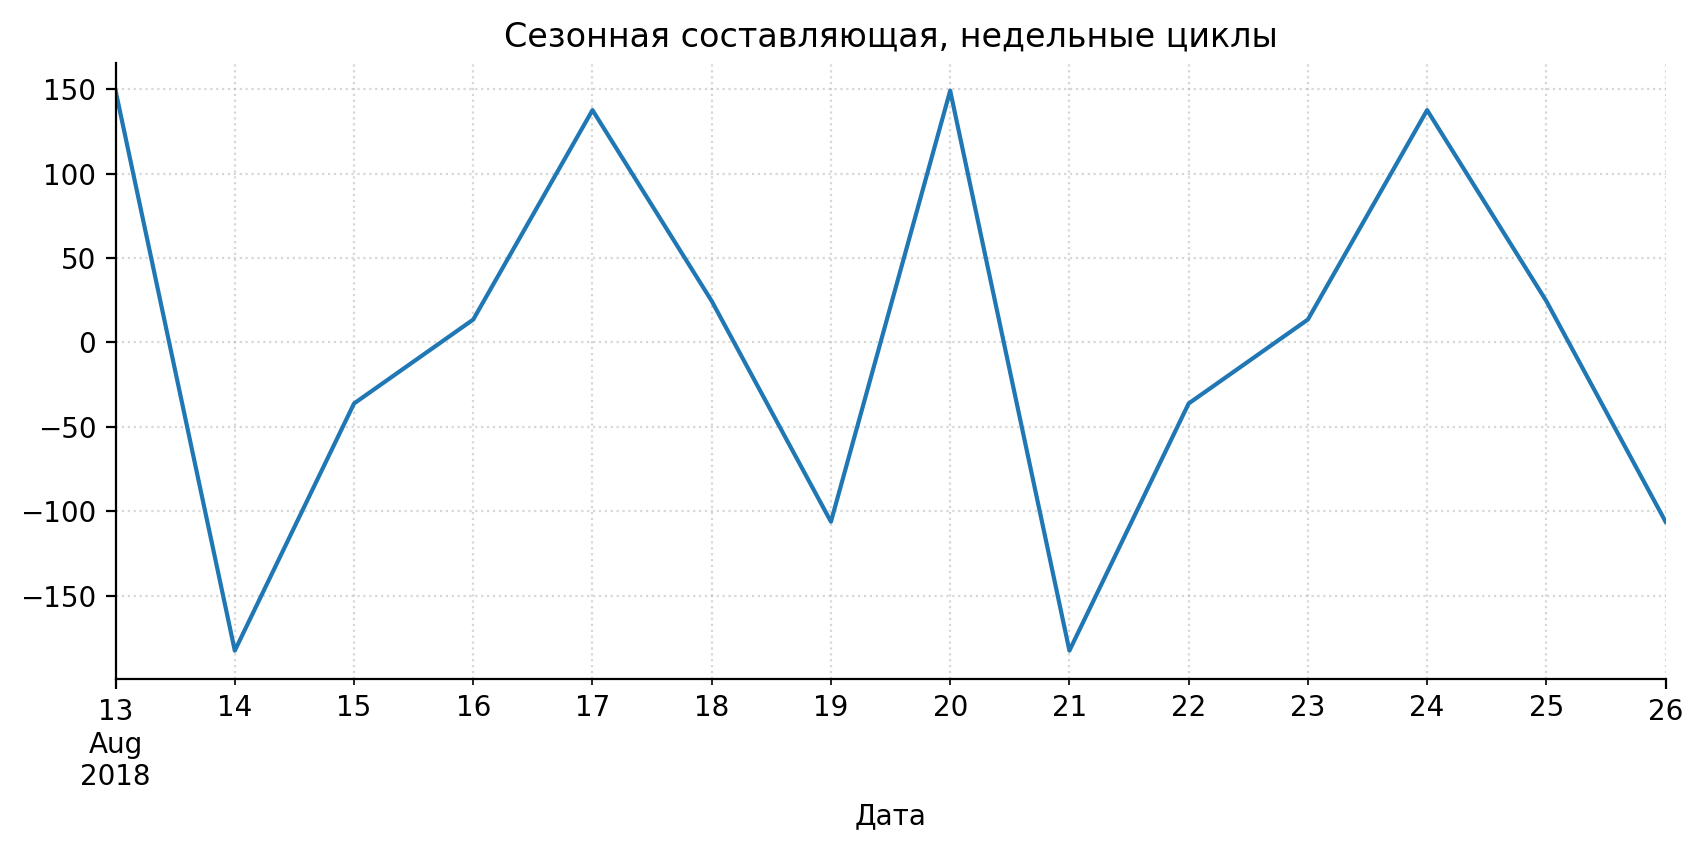

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

decomposed_taxi_1d.seasonal['2018-08-13':'2018-08-26'].plot(ax=ax)
ax.set_title('Сезонная составляющая, недельные циклы')
ax.set_xlabel('Дата')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='both', which='both', alpha=0.5, linestyle=':')

plt.show()

#### Ресемплирование по часам

Попробуем выделить тренд и сезонность из данных, ресемплированных по часам.

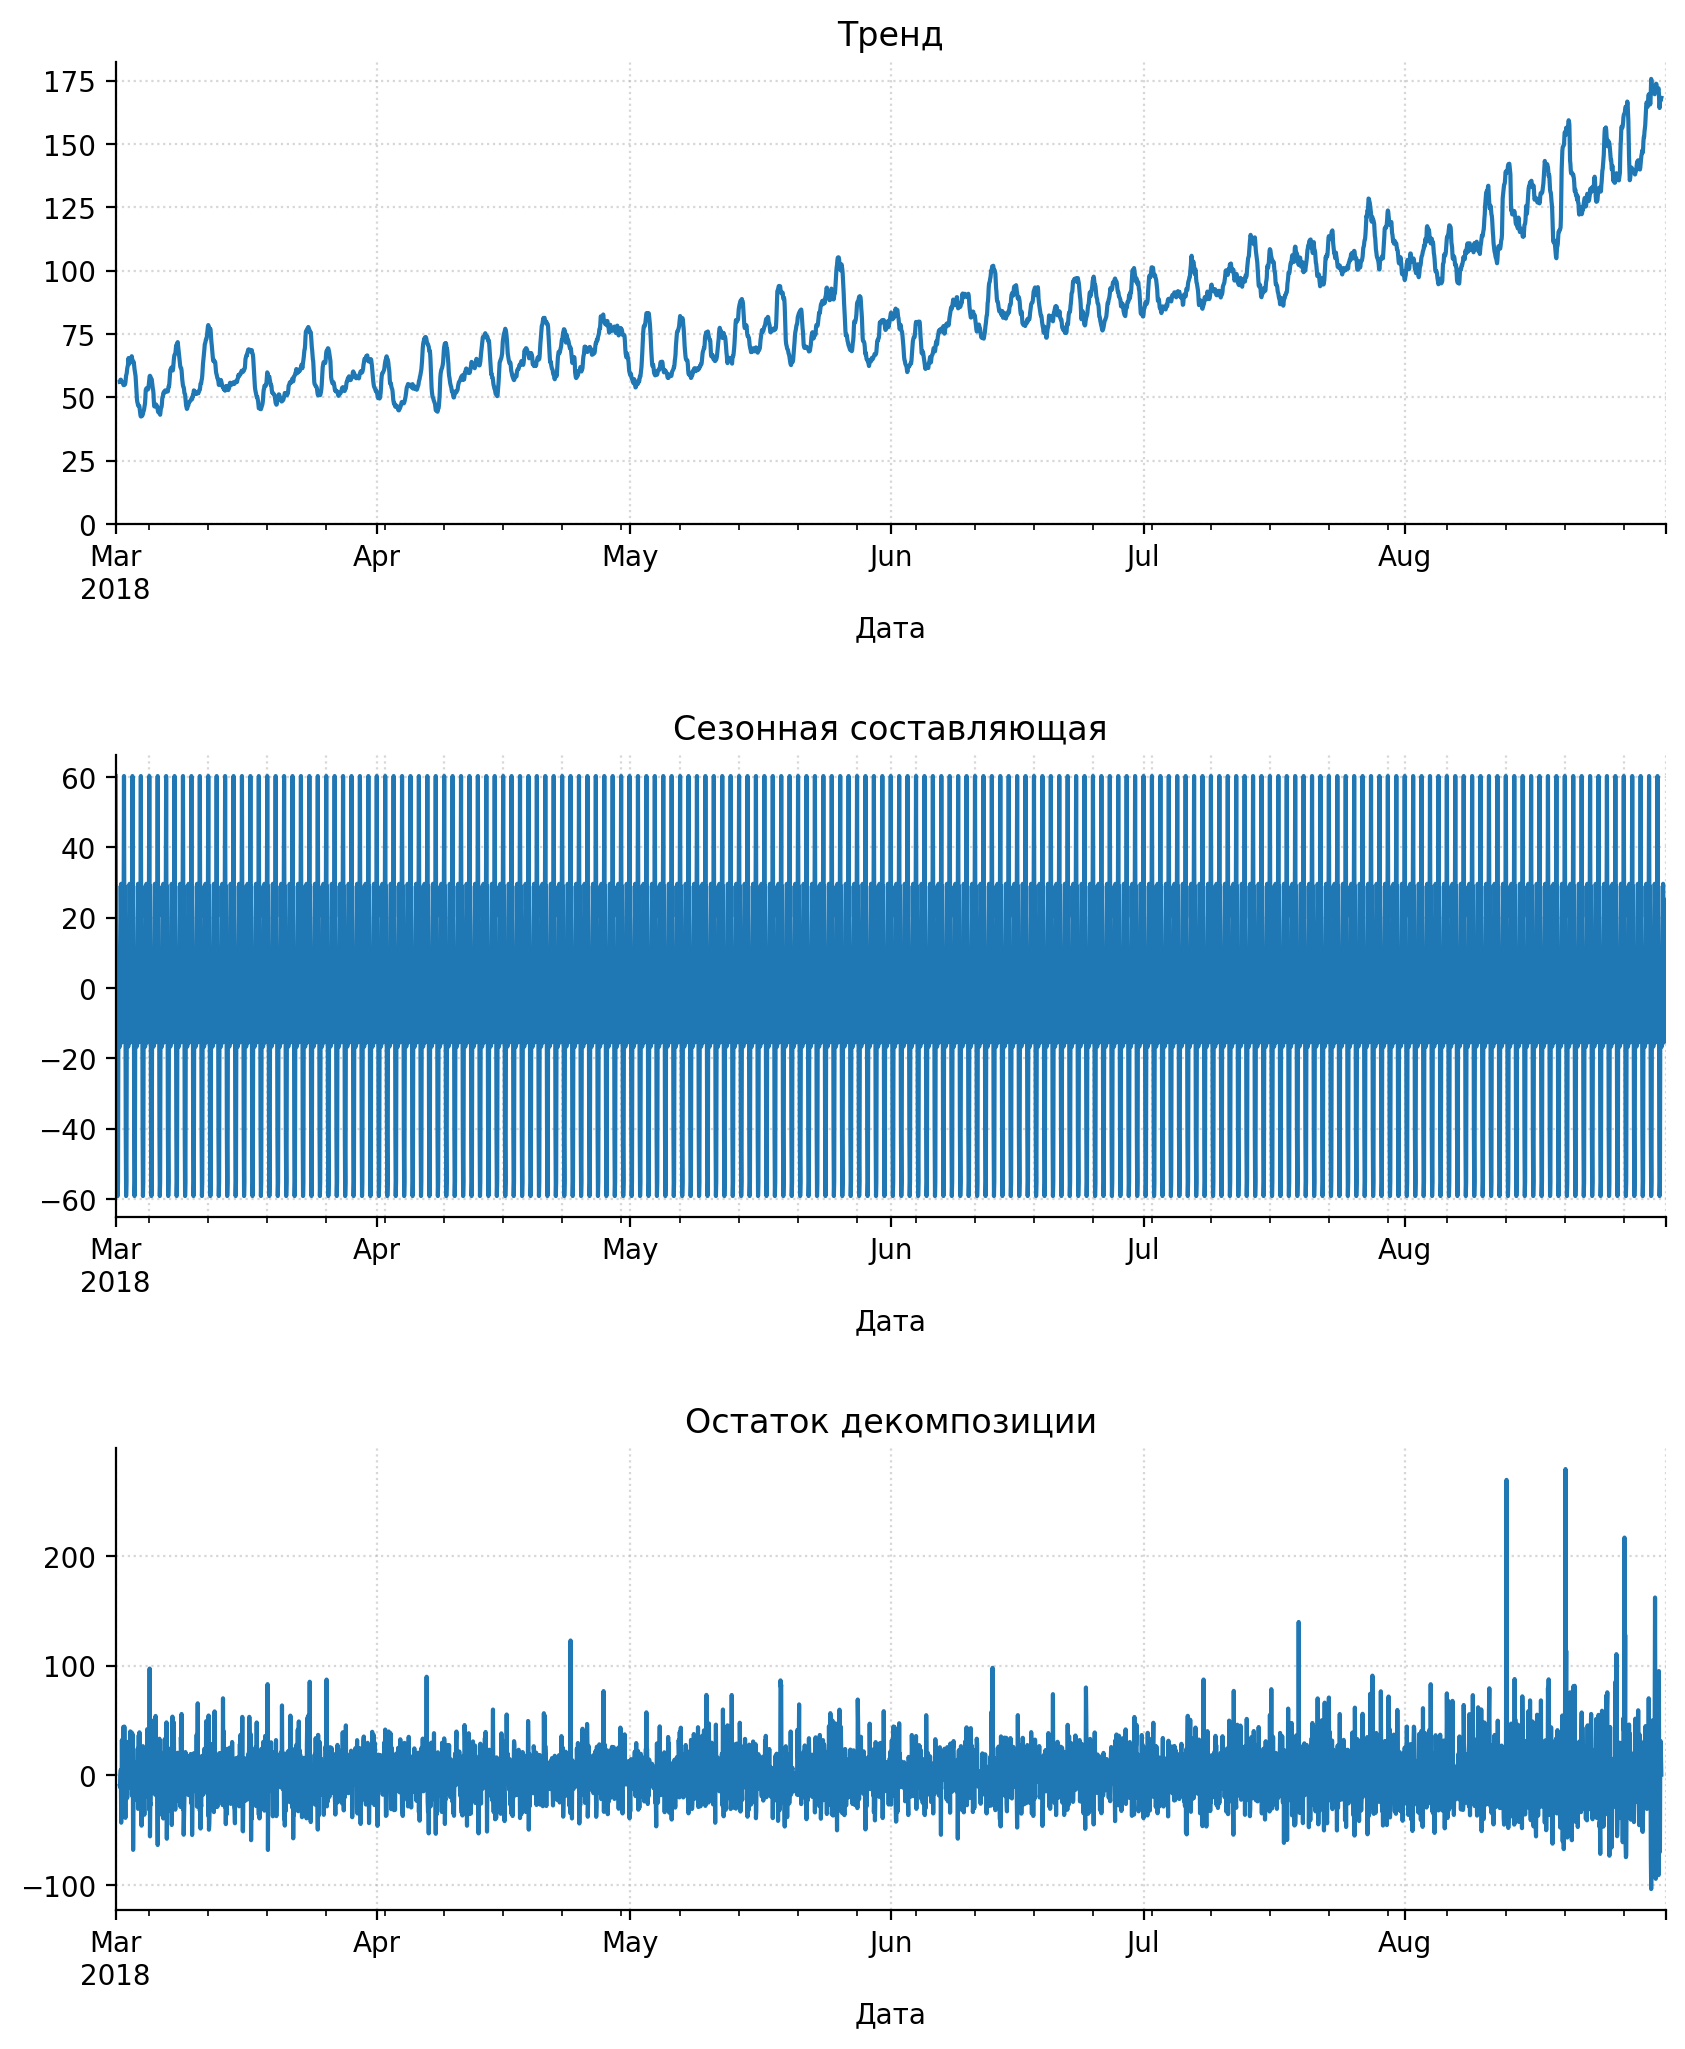

In [54]:
decomposed_taxi_1h = seasonal_decompose(taxi_1h)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.subplots_adjust(hspace=0.5)
display_seasonal_decompose(decomposed_taxi_1h, ax1, ax2, ax3)
plt.show()

Посмотрим на сезонную составляющую внимательнее.

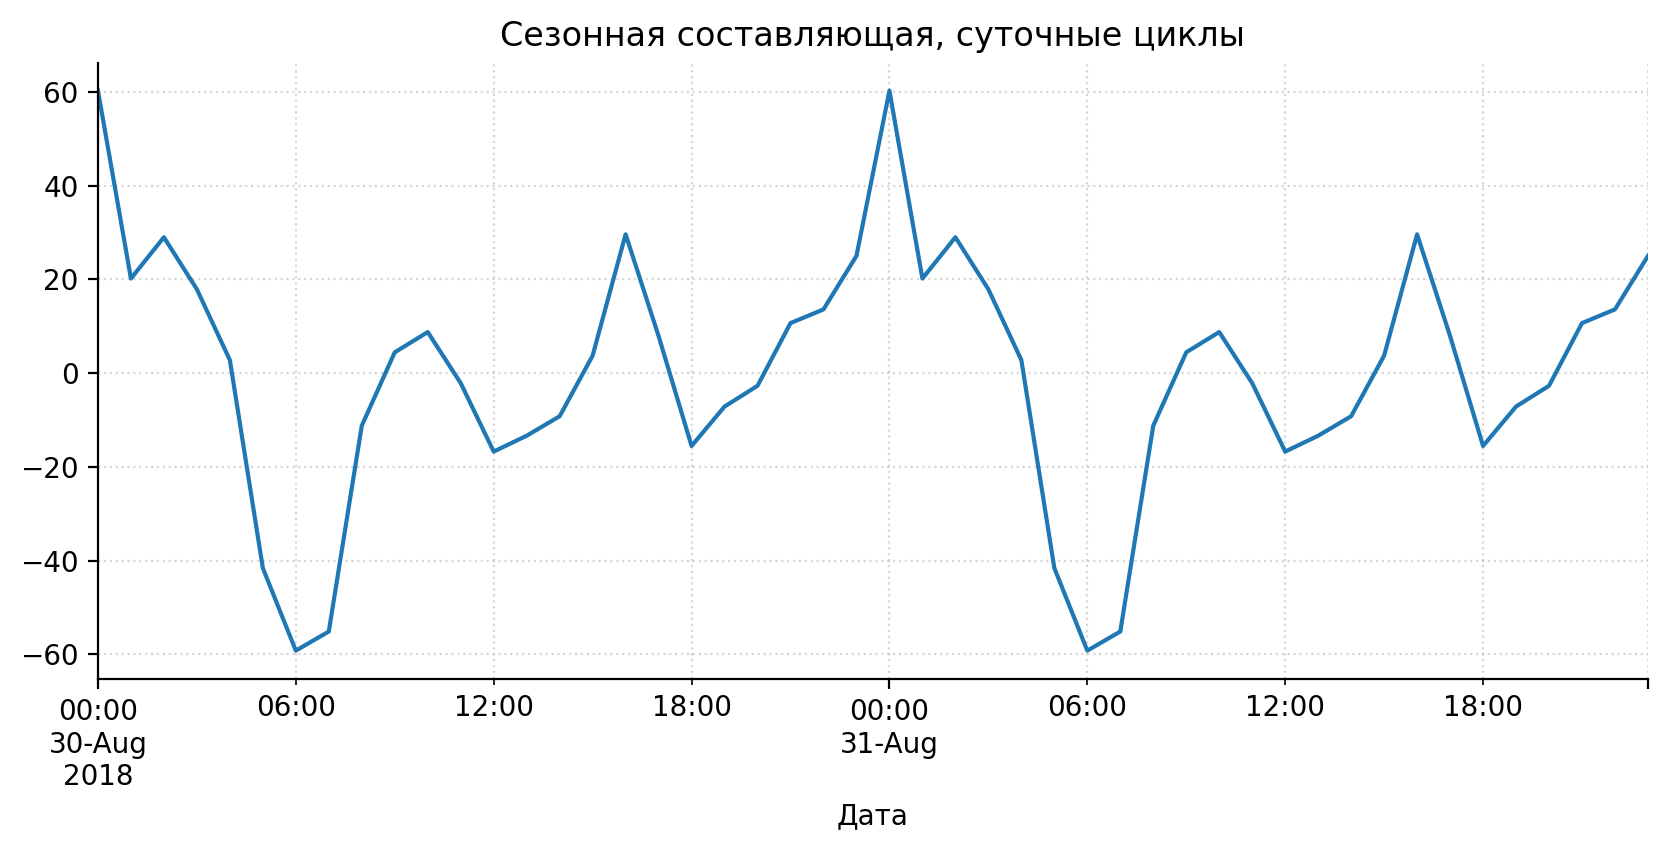

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

decomposed_taxi_1h.seasonal['2018-08-30':'2018-08-31'].plot(ax=ax)
ax.set_title('Сезонная составляющая, суточные циклы')
ax.set_xlabel('Дата')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='both', which='both', alpha=0.5, linestyle=':')

plt.show()

Выделение тренда и сезонности из временного ряда позволило обнаружить цикличность (суточную и недельную) в заказах такси, а также тренд на увеличение количества заказов с начала весны по конец лета 2018 года. Наибольшее количество заказов наблюдается в полночь и падает до минимальных значений к 6 утра. Также стоит отметить, что максимальное количество заказов наблюдается по понедельникам и пятницам.

При этом мы видим достаточно сильный шум, который не объясняется трендом и сезонностью. Это могут быть различные факторы, например, плохая погода — ливни и грозы, крупные культурные и спортивные мероприятия, пробки на дорогах и так далее.

### Создание новых признаков

Создадим признаки для горизонта прогнозирования в один шаг:
- календарные признаки: месяц, день, день недели;
- отстающие значения: количество заказов с лагами в час, два часа, сутки, двое суток и неделю;
- скользящее среднее с размером окна в одни сутки.

In [60]:
taxi_1h_modified = add_features(taxi_1h, [1, 2, 24, 24 * 2, 24 * 7], 24)
taxi_1h_modified.head()

,num_orders,month,day,dayofweek,rolling_mean,num_orders_lag_1,num_orders_lag_2,num_orders_lag_24,num_orders_lag_48,num_orders_lag_168
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,NaN,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,NaN,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,NaN,71.0,85.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,NaN,66.0,71.0,NaN,NaN,NaN


Рассчитаем коэффициенты корреляции Фи между всеми признаками. Посмотрим тепловую карту матрицы корреляций.

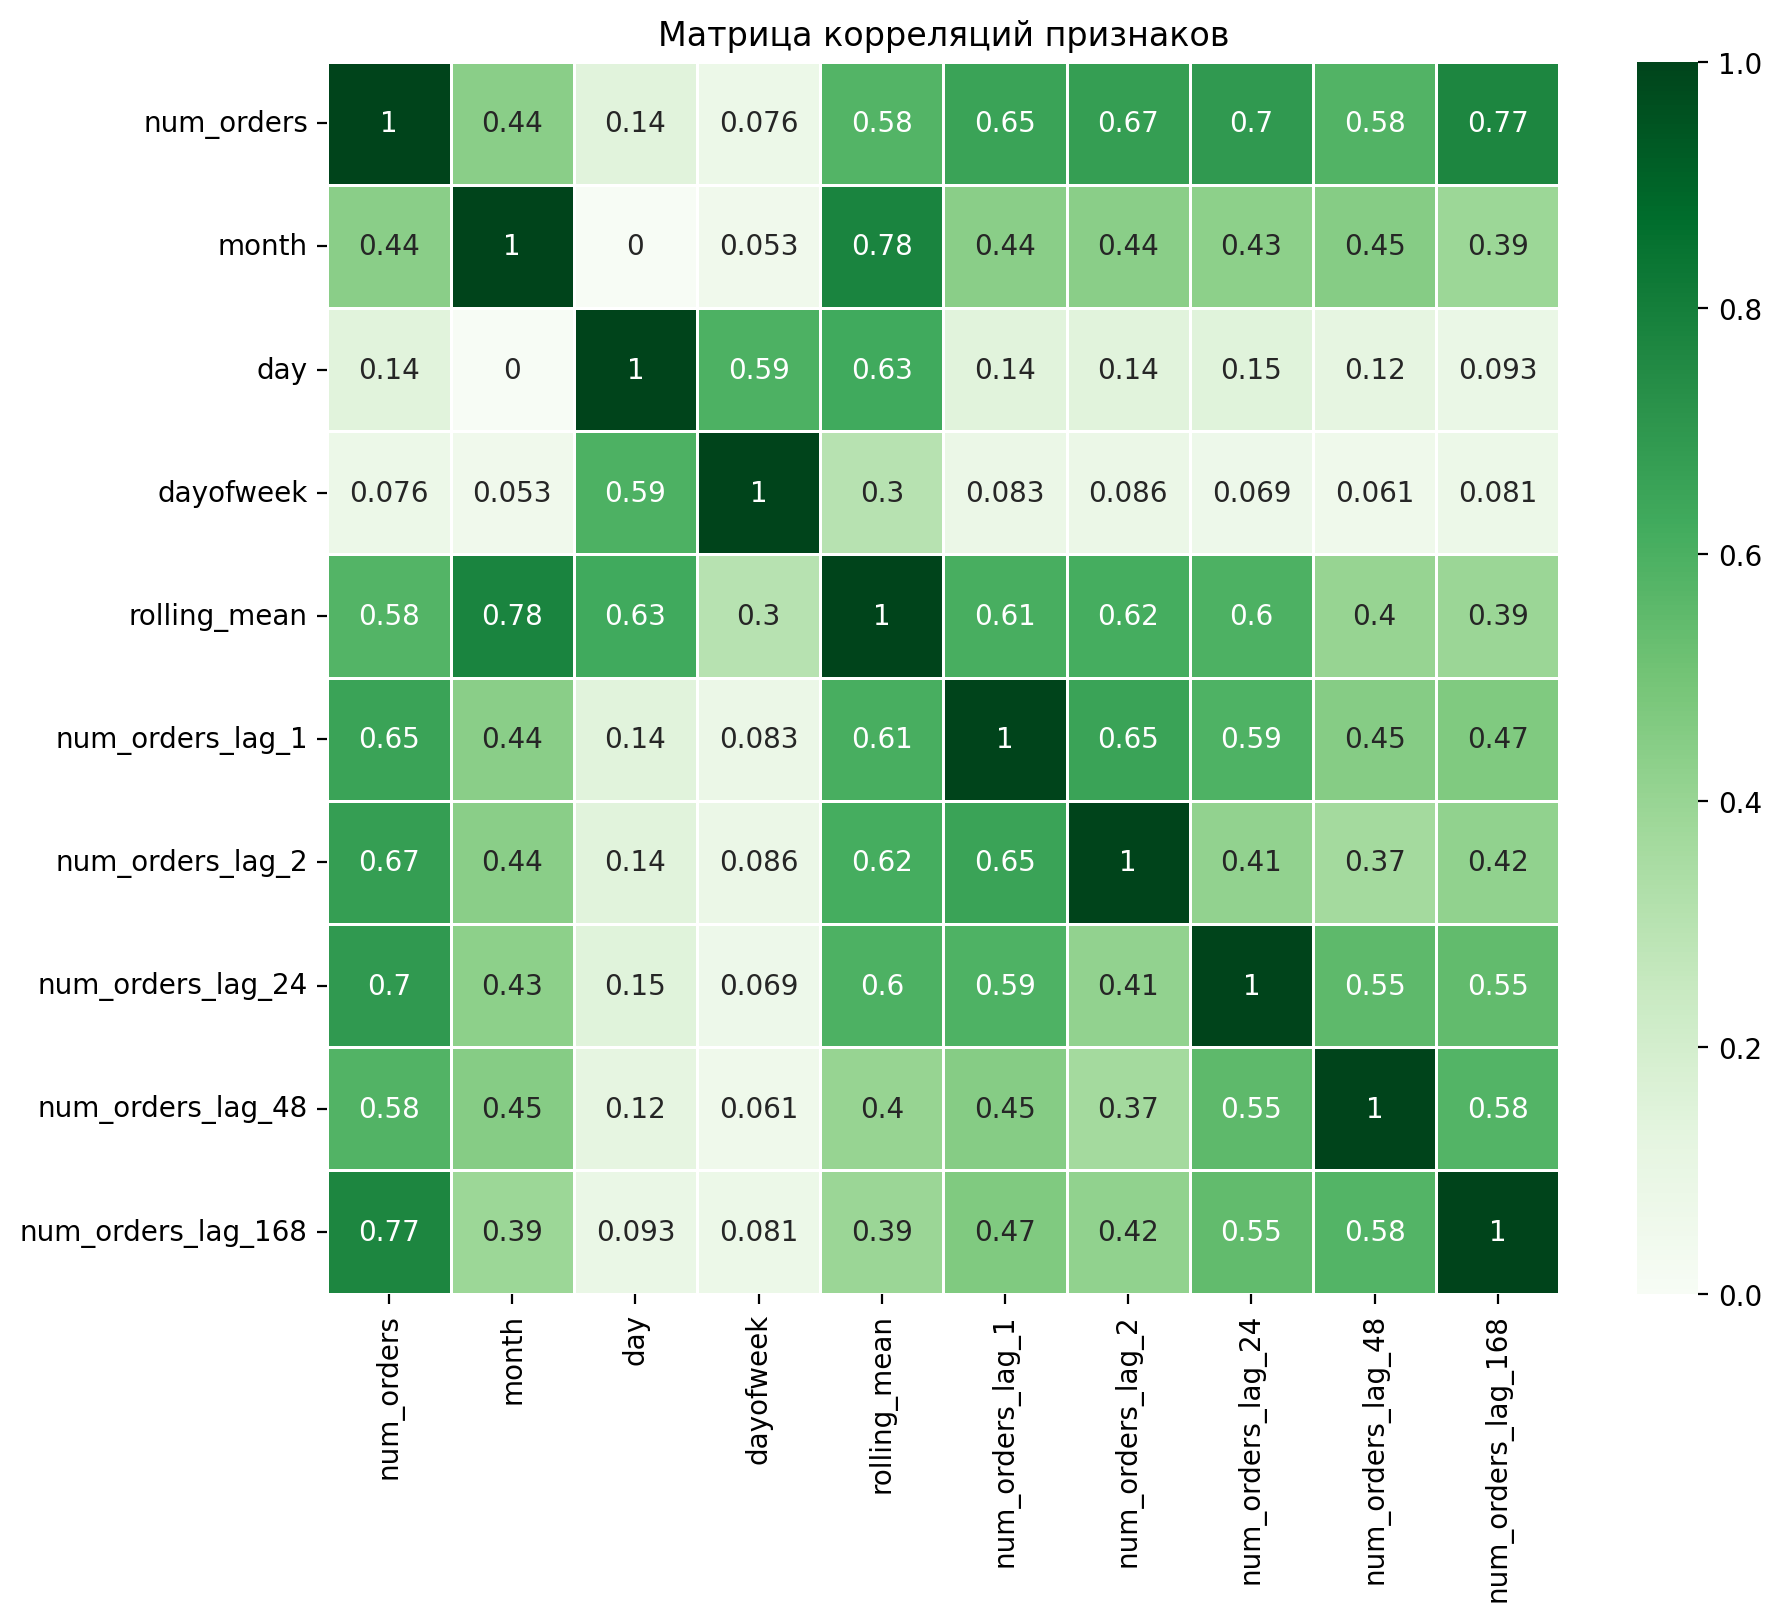

In [62]:
interval_columns = set(taxi_1h_modified.columns) - {'month', 'day', 'dayofweek'}
corr_coefficients = taxi_1h_modified.phik_matrix(interval_cols=interval_columns)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(corr_coefficients, annot=True, square=True, linewidths=0.5, cmap='Greens', ax=ax)
ax.set_title('Матрица корреляций признаков')
plt.show()

С учетом значений коэффициетов корреляции с целевым признаком, добавление новых признаков выглядит оправданным.

## Обучение

Разделим временной ряд на тренировочную и тестовую выборки.

In [66]:
train, test = train_test_split(taxi_1h_modified, test_size=0.1, shuffle=False)
train.dropna(inplace=True)

display(f'Тренировочная выборка: {train.index[0]} — {train.index[-1]}')
display(f'Тестовая выборка:      {test.index[0]} — {test.index[-1]}')

X_train, y_train = train.drop('num_orders', axis=1), train['num_orders']
X_test, y_test = test.drop('num_orders', axis=1), test['num_orders']

'Тренировочная выборка: 2018-03-08 00:00:00 — 2018-08-13 13:00:00'

'Тестовая выборка:      2018-08-13 14:00:00 — 2018-08-31 23:00:00'

Подготовим пайплайн модели, включающий масштабирование признаков, отбор признаков и саму модель.

In [68]:
model_pipe = Pipeline(
    steps=[
        ('scaler', 'passthrough'), 
        ('selector', SelectKBest(f_regression)),
        ('model', LinearRegression())
    ]
)

Подберем гиперпараметры с помощью класса `GridSearchCV`. Для оценки качества модели применим метрику *RMSE* — корень среднеквадратичной ошибки.

Для разбиения временного ряда на выборки при кросс-валидации будем пользоваться классом `TimeSeriesSplit` чтобы оценивать модель строго на будущих наблюдениях.

В качестве одной из тестируемых моделей возьмем собственную дамми-модель `MyDummyModel`, делающую предсказание целевого признака по указанному входному признаку, домноженному на отношение средних значений таргета и входного признака в обучающей выборке.

In [70]:
%%time

model_pipe = Pipeline(
    steps=[
        ('scaler', 'passthrough'), 
        ('selector', SelectKBest(f_regression)),
        ('model', LinearRegression())
    ]
)

param_grid = [
    {
        'selector': ['passthrough'],
        'model': [MyDummyModel()],
        'model__base_feature': ['num_orders_lag_1', 'num_orders_lag_24', 'num_orders_lag_168']
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
        'selector__k': range(5, X_train.shape[1] + 1),
        'model': [LinearRegression()],
        'model__fit_intercept': [True, False]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
        'selector__k': range(5, X_train.shape[1] + 1),
        'model': [SVR()],
        'model__kernel': ['linear', 'poly'],
        'model__degree': [2, 3]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
        'selector__k': range(5, X_train.shape[1] + 1),
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': range(1, 11),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
        'selector__k': range(5, X_train.shape[1] + 1),
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(1, X_train.shape[1] + 1),
        'model__max_features': range(1, X_train.shape[1] + 1),
        'model__min_samples_split': [5, 10, 20]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
        'selector__k': range(5, X_train.shape[1] + 1),
        'model': [CatBoostRegressor(iterations=20, loss_function='RMSE', verbose=False,
                                    random_state=RANDOM_STATE)],
        'model__grow_policy': ['Depthwise', 'SymmetricTree']
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), 'passthrough'],
        'selector__k': range(5, X_train.shape[1] + 1),
        'model': [LGBMRegressor(metric='rmse', verbose=0, random_state=RANDOM_STATE)],
        'model__boosting_type': ['gbdt', 'dart'],
        'model__min_child_samples': range(10, 80, 10)
    }
]

model_search = GridSearchCV(
    model_pipe, 
    param_grid, 
    cv=TimeSeriesSplit(n_splits=5), 
    n_jobs=-1, 
    scoring='neg_root_mean_squared_error'
)

model_search.fit(X_train, y_train)
f'RMSE лучшей модели при кросс-валидации: {-model_search.best_score_:.2f} заказов'

CPU times: total: 1min 10s
Wall time: 5min 53s


'RMSE лучшей модели при кросс-валидации: 22.44 заказов'

Посмотрим на результаты лучших моделей каждого типа.

In [72]:
results = pd.DataFrame(model_search.cv_results_)[['param_model', 'params', 'rank_test_score', 'mean_test_score']]
results['param_model'] = results['param_model'].apply(lambda x: x.__class__.__name__)
results['mean_test_score'] = np.round(-results['mean_test_score'], 2)

results.sort_values(by='rank_test_score') \
       .pivot_table(index='param_model', aggfunc='first') \
       .sort_values(by='rank_test_score') \
       .reset_index() \
       .rename(columns={'param_model': 'Модель',
                        'mean_test_score': 'RMSE при кросс-валидации', 
                        'params': 'Параметры модели',
                        'rank_test_score': 'Ранг'}) \
       [['Модель', 'Ранг', 'RMSE при кросс-валидации', 'Параметры модели']]

,Модель,Ранг,RMSE при кросс-валидации,Параметры модели
0,SVR,1,22.44,"{'model': SVR(), 'model__degree': 2, 'model__kernel': 'linear', 'scaler': 'passthrough', 'selector__k': 6}"
1,LinearRegression,5,22.48,"{'model': LinearRegression(), 'model__fit_intercept': False, 'scaler': 'passthrough', 'selector__k': 6}"
2,LGBMRegressor,46,23.15,"{'model': LGBMRegressor(metric='rmse', random_state=42, verbose=0), 'model__boosting_type': 'gbdt', 'model__min_child_samples': 60, 'scaler': StandardScaler(), 'selector__k': 9}"
3,CatBoostRegressor,84,23.49,"{'model': <catboost.core.CatBoostRegressor object at 0x000001D025D81F40>, 'model__grow_policy': 'SymmetricTree', 'scaler': MinMaxScaler(), 'selector__k': 7}"
4,KNeighborsRegressor,98,23.61,"{'model': KNeighborsRegressor(), 'model__n_neighbors': 10, 'model__p': 2, 'model__weights': 'uniform', 'scaler': 'passthrough', 'selector__k': 6}"
5,DecisionTreeRegressor,561,24.79,"{'model': DecisionTreeRegressor(random_state=42), 'model__max_depth': 5, 'model__max_features': 4, 'model__min_samples_split': 20, 'scaler': MinMaxScaler(), 'selector__k': 7}"
6,MyDummyModel,1800,26.38,"{'model': MyDummyModel(), 'model__base_feature': 'num_orders_lag_168', 'selector': 'passthrough'}"


Можно отметить, что все тестируемые модели показали неплохие результаты. Однако лучший результат при кросс-валидации (*RMSE*=22.44) показал метод опорных векторов `SVR` с линейным ядром. При этом модель использовала не все входные признаки, а только 6 них:

In [74]:
idxs = model_search.best_estimator_.named_steps['selector'].get_support(indices=False)
model_search_used_columns = X_train.iloc[:, idxs].columns.tolist()
model_search_used_columns

['month',
 'rolling_mean',
 'num_orders_lag_1',
 'num_orders_lag_24',
 'num_orders_lag_48',
 'num_orders_lag_168']

## Тестирование

Посмотрим на метрику *RMSE* выбранной модели `SVR` на тестовых данных.

In [77]:
predict = model_search.predict(X_test)
f'RMSE на тестовой выборке: {mean_squared_error(y_test, predict, squared=False):.2f} заказов'

'RMSE на тестовой выборке: 34.78 заказов'

Требуемый результат достигнут (значение метрики *RMSE* на тестовой выборке должно быть не больше 48).

Посмотрим на распределение остатков выбранной модели.

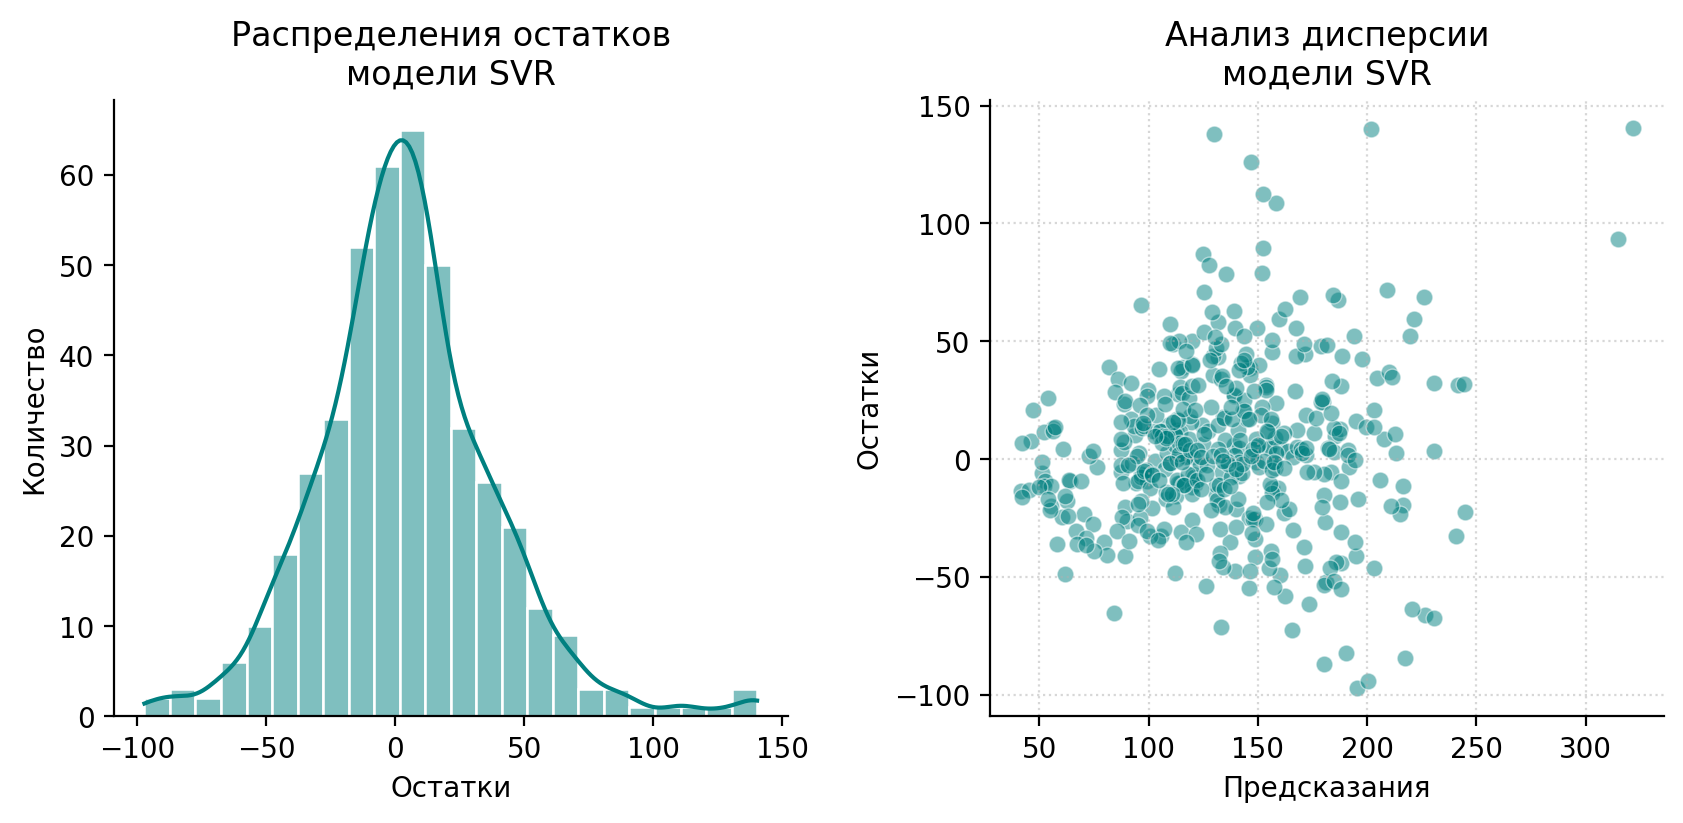

In [80]:
residuals = y_test - predict

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.3)

sns.histplot(x=residuals, ax=ax1, kde=True, kde_kws={'bw_method': 0.2}, edgecolor='white', color='teal')
ax1.set_title(f'Распределения остатков\nмодели SVR')
ax1.set_xlabel('Остатки')
ax1.set_ylabel('Количество')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sns.scatterplot(x=predict, y=residuals, ax=ax2, alpha=0.5, color='teal')
ax2.set_title(f'Анализ дисперсии\nмодели SVR')
ax2.set_xlabel('Предсказания')
ax2.set_ylabel('Остатки')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(alpha=0.5, linestyle=':')

plt.show()

Распределение близко к нормальному со средним около 0.

Оценим перестановочную важность признаков.

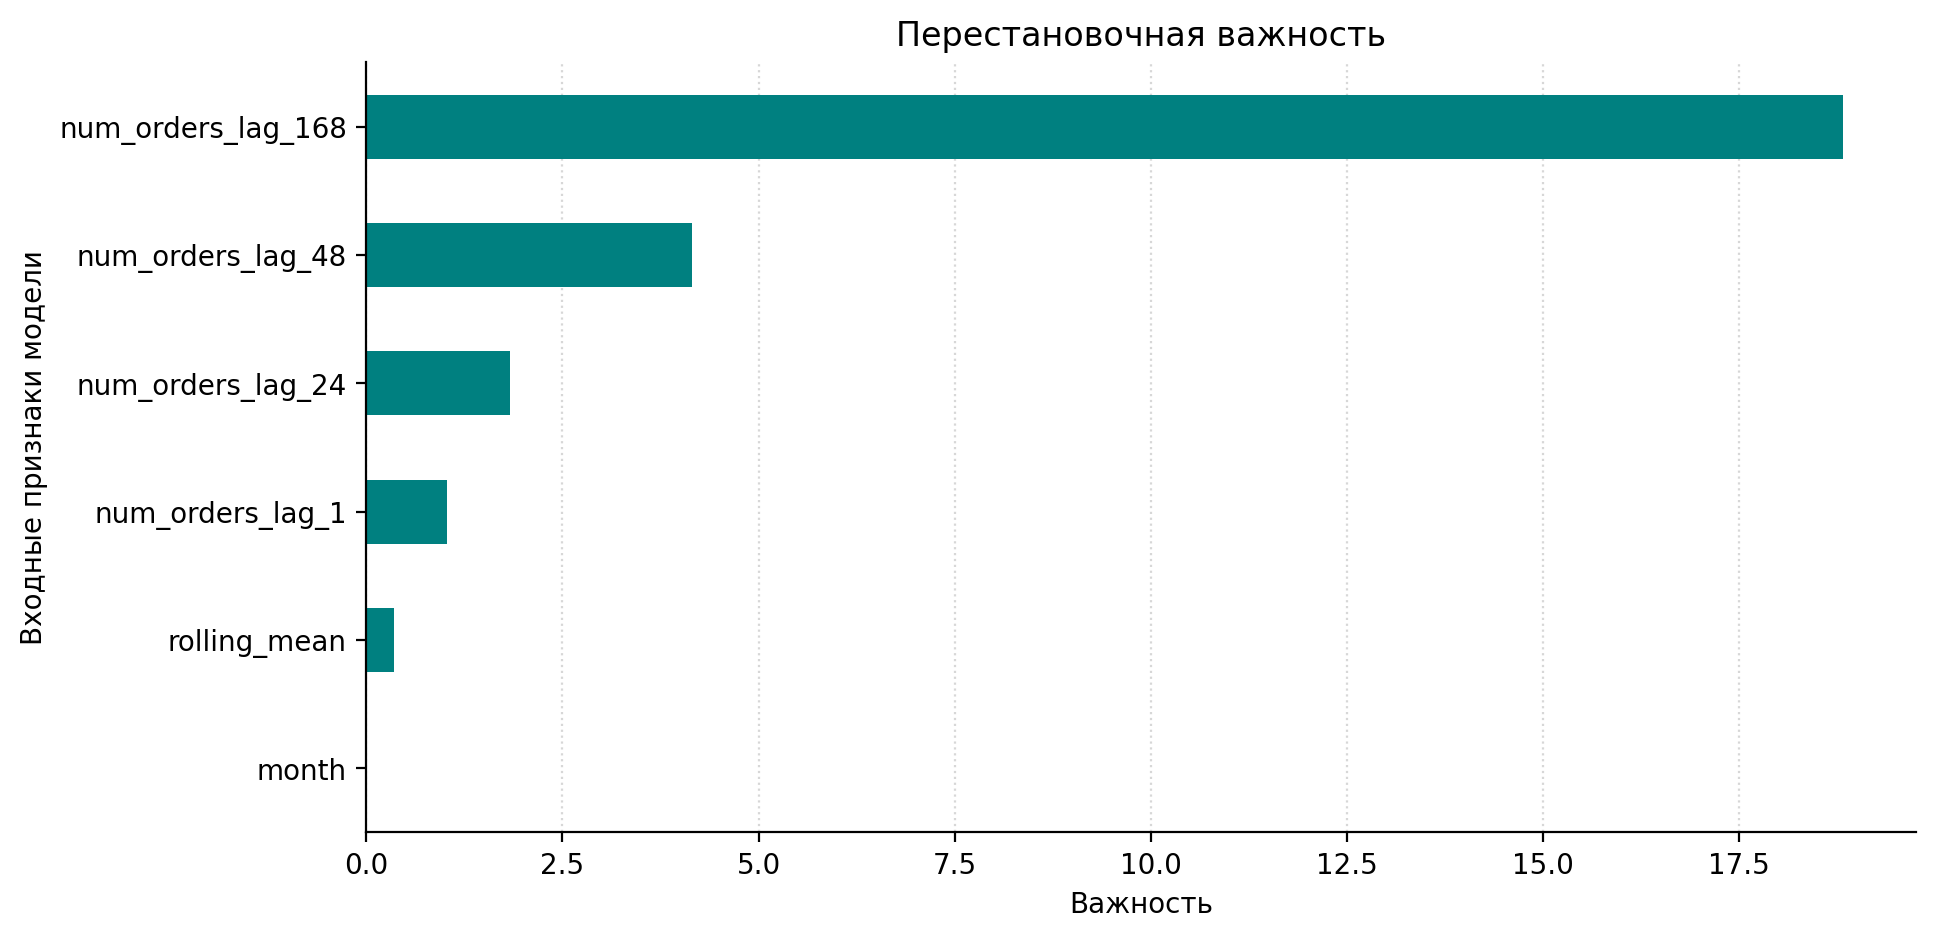

In [83]:
permutation = permutation_importance(model_search, X_test, y_test, scoring='neg_root_mean_squared_error', 
                                     random_state=RANDOM_STATE)

feature_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance': permutation['importances_mean']
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
feature_importances[feature_importances['feature'].isin(model_search_used_columns)].plot(
    x='feature', y='importance', kind='barh', legend=False, color='teal', ax=ax
)
ax.set_title('Перестановочная важность')
ax.set_xlabel('Важность')
ax.set_ylabel('Входные признаки модели')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')
plt.show()

Наибольшее влияние на предсказания модели оказывает количество заказов с лагом в неделю.

Построим графики тестового и предсказанного рядов.

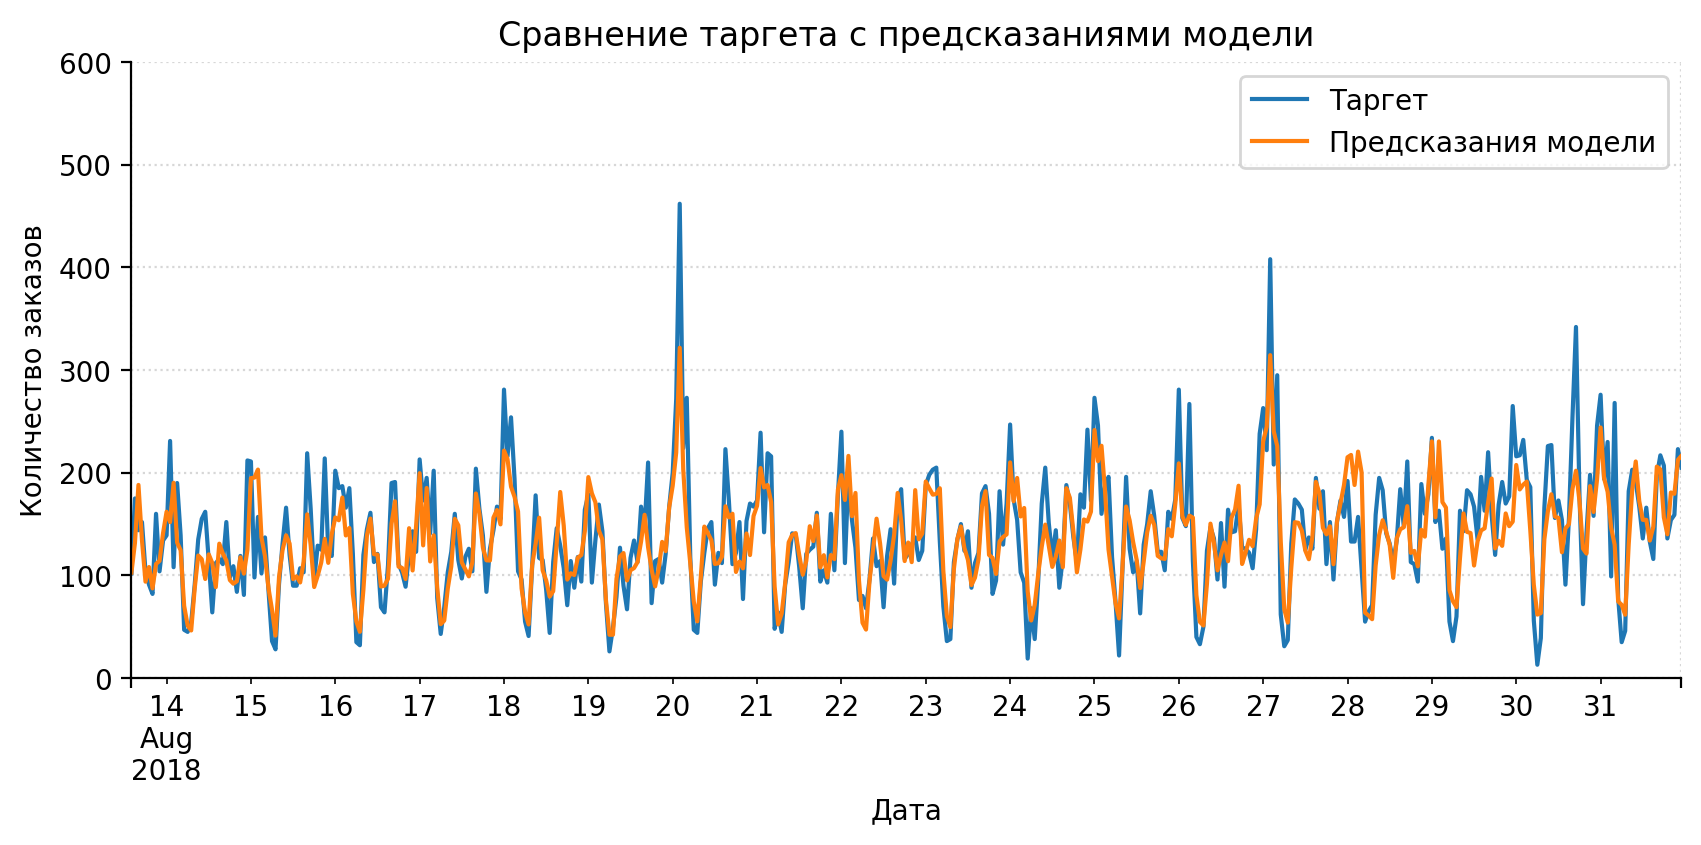

In [86]:
fig, ax = plt.subplots(figsize=(10, 4))

pd.DataFrame({'target': y_test, 'predict': predict}, index=y_test.index).plot(ax=ax)
ax.set_title('Сравнение таргета с предсказаниями модели')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов')
ax.set_ylim(top=600, bottom=0)
ax.legend(['Таргет', 'Предсказания модели'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

## Общий вывод

В ходе исследования обработаны и проанализированы исторические данные о заказах такси в аэропортах. Построены модели, предсказывающие количество заказов такси на следующий час. Построенные модели проанализированы, и выбрана модель, наиболее подходящая под критерий оценки качества.

В результате **предобработки данных** пропусков, дубликатов и аномалий не обнаружено. Временной ряд содержит данные с 1 марта 2018 года по 31 августа 2018 года. **Анализ данных** позволил обнаружить цикличность (суточную и недельную) в заказах такси, а также тренд на увеличение количества заказов.

Перед обучением моделей были созданы признаки для горизонта прогнозирования в один шаг: календарные признаки, отстающие значения и скользящее среднее.

По результатам **обучения и анализа моделей**, предсказывающих количество заказов такси на следующий час, рекомендуется использовать метод опорных векторов `SVR` с линейным ядром, который удовлетворяет критерию оценки качества (значение метрики *RMSE*=34.78 на тестовых данных).

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48